# PriorCVAE: scalable MCMC parameter inference with Bayesian deep generative modelling

## PriorCVAE wokflow


- Draws from a prior such as a GP with conditioning on hyperparameter $c$, are encoded with a CVAE. 
- Once trained, the decoder from this trained CVAE is fixed. 
- Fully Bayesian inference with MCMC is used to combine a likelihood with a prior to infer a posterior. The prior is the drop-in prior expressed as the trained CVAE decoder, which is an approximation to the true prior from the previous step. A hyperprior is placed on $c$, with given draws from this prior passed to the CVAE decoder.


In [1]:
# general
import os
import sys
import time
import numpy as np 
import matplotlib.pyplot as plt 

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
#from tqdm import tqdm, trange

# Numpyro
import numpyro
import numpyro.distributions as npdist
import random as rnd
from numpyro.infer import Predictive, init_to_median, MCMC, NUTS
from numpyro.diagnostics import hpdi

numpyro.set_host_device_count(4)

#JAX
import jax
from jax import random
import jax.numpy as jnp

# check versions
print(numpyro.__version__)
print(jax.__version__)
print(torch.__version__)
from platform import python_version
print(python_version())

0.10.1
0.3.25
1.12.1
3.8.16


In [2]:
# set device
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
args = {"seed": 0,
        
        # architecture
        "conditional": True,
        "input_dim": 80,
        "hidden_dim": 60,
        "z_dim": 40,
        
        # data generation
        "new_data": True,  # set to True to generate new data. Otherwise read from file
        "save_data": True, # set to True to save generated training and test datasets
        "batch_size": 500,
        "samples": 100000,
        
        # VAE setup
        "vae_sd": 1, 
        "n_epochs": 800,
        "learning_rate": 1e-3,
        "train_vae": True,      # set to True to train VAE
        "save_vae": False,
        "load_vae": False,      # set to True to load trained CVAE
        
        # MCMC setup
        "num_warmup": 1000,
        "num_samples": 4000,
        "num_chains": 4,
        "thinning": 1,
        "true_ls": 0.2
       }

## GP priors

In [9]:
def dist_euclid(x, z):
    x = jnp.array(x) 
    z = jnp.array(z)
    if len(x.shape)==1:
        x = x.reshape(x.shape[0], 1)
    if len(z.shape)==1:
        z = z.reshape(z.shape[0], 1)
    n_x, m = x.shape
    n_z, m_z = z.shape
    assert m == m_z
    delta = jnp.zeros((n_x,n_z))
    for d in jnp.arange(m):
        x_d = x[:,d]
        z_d = z[:,d]
        delta += (x_d[:,jnp.newaxis] - z_d)**2
    return jnp.sqrt(delta)

def exp_sq_kernel(x, z, var, length, noise=0, jitter=1.0e-5):
    dist = dist_euclid(x, z)
    deltaXsq = jnp.power(dist/ length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    k += (noise + jitter) * jnp.eye(x.shape[0])
    return k

def GP(x, jitter=1e-5, var=1.0, length=None, y=None, noise=False, gp_kernel=exp_sq_kernel):

    if length==None:  
        length = numpyro.sample("length", npdist.Uniform(0.01,0.99)) 
            
    k = gp_kernel(x, x, var, length, jitter)
    
    if noise==False:
        y = numpyro.sample("y",  npdist.MultivariateNormal(loc=jnp.zeros(x.shape[0]), covariance_matrix=k), obs=y)
    else:
        sigma = numpyro.sample("noise", npdist.HalfNormal(0.1))
        f = numpyro.sample("f", npdist.MultivariateNormal(loc=jnp.zeros(x.shape[0]), covariance_matrix=k))
        y = numpyro.sample("y", npdist.Normal(f, sigma), obs=y)
    
    ls = numpyro.deterministic("ls", jnp.array([length]))

## Generate data - 1d GP

In [10]:
class GP1D(Dataset):
    def __init__(self, n_dataPoints=400, 
                       n_samples=10000, 
                       x_lim_low = 0, 
                       x_lim_high = 1,
                       ls = None
                 ): 
        self.n_dataPoints = n_dataPoints
        self.n_samples = n_samples
        self.x_lim_low = x_lim_low
        self.x_lim_high = x_lim_high
        self.ls = ls
        self.x, self.y, self.ls = self.__simulatedata__()
    
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx=0):
        return(self.x[idx], self.y[idx], self.ls[idx])

    def __simulatedata__(self):
        rng_key = rnd.randint(0, 912393890428)
        rng_key, _ = random.split(random.PRNGKey(rng_key))
        x = np.linspace(self.x_lim_low, self.x_lim_high, self.n_dataPoints)   
        gp_predictive = Predictive(GP, num_samples=self.n_samples)  
        all_draws = gp_predictive(rng_key, x=x, gp_kernel = exp_sq_kernel, jitter=1e-6, length=self.ls)

        ls_draws = np.array(all_draws['ls'])
        gp_draws = np.array(all_draws['y'])
        
        return (x.repeat(self.n_samples).reshape(x.shape[0], self.n_samples).transpose(), gp_draws, ls_draws)

(0.0, 1.0)

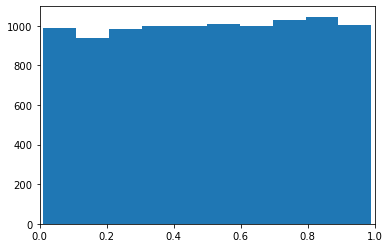

In [11]:
# what lengthscales are we generating?
dataset = GP1D(n_dataPoints=args["input_dim"])
ls_dataset = dataset.ls
plt.hist(ls_dataset) 
plt.xlim(0,1)

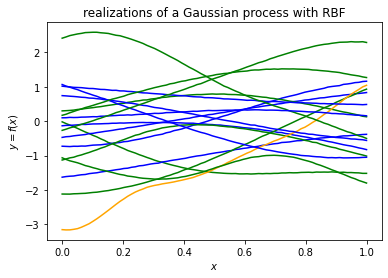

In [12]:
# what trajectories are we getting?
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

fig, ax = plt.subplots()
for no, dt in enumerate(dataloader):
    if dt[2] <= 0.2:
        col = 'orange'  
    elif dt[2] <= 0.6:
        col = 'green'
    else: 
        col = 'blue'
    ax.plot(dt[0].reshape(-1,1), dt[1].reshape(-1,1), color=col)
    if no > 15: break
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f(x)$')
ax.set_title('realizations of a Gaussian process with RBF')

plt.show()

In [14]:
###### create or read training and test data
cwd = os.getcwd()
train_ds_name = 'gp1d_n' + str(args["input_dim"]) + '_train.pt'
test_ds_name = 'gp1d_n' + str(args["input_dim"]) + '_test.pt'
PATH_train = cwd+ "/data/gp1d/{train_ds_name}"
PATH_test =  cwd+"/data/gp1d/{test_ds_name}" 
    
if args["new_data"] == True:
    print("Generating new data")
    train_ds = GP1D(n_dataPoints=args["input_dim"], n_samples=args["samples"])
    test_ds = GP1D(n_dataPoints=args["input_dim"], n_samples=args["samples"])
    torch.save(train_ds, PATH_train)
    torch.save(test_ds, PATH_test)
else:
    print("Loading data")
    train_ds = torch.load(PATH_train)
    test_ds = torch.load(PATH_test)
    
test_dl = DataLoader(test_ds, batch_size=args["batch_size"], shuffle=True)
train_dl = DataLoader(train_ds, batch_size=args["batch_size"], shuffle=True)

# check distribution of lengthscales in training and test data
ls_train = train_ds.ls
plt.hist(ls_train, density=True) 
plt.xlim(0,1)
plt.show()

ls_test = test_ds.ls
plt.hist(ls_test, density=True) 
plt.xlim(0,1)
plt.show()

Generating new data


FileNotFoundError: [Errno 2] No such file or directory: '/Users/es/Dropbox/00 Oxford/39_CVAE/PyTorch/Python/for_paper/PriorCVAE/experiments../data/gp1d/{train_ds_name}'

## CVAE architecture

In [ ]:
class Encoder(nn.Module):
    ''' This the encoder part of CVAE
    '''
    def __init__(self, input_dim, hidden_dim, z_dim, conditional):
        super().__init__()
        self.conditional = conditional
        if self.conditional:
            input_dim = input_dim + 1
        
        self.linear = nn.Linear(input_dim, hidden_dim)
        self.mu = nn.Linear(hidden_dim, z_dim)
        self.sd = nn.Linear(hidden_dim, z_dim)
        
    def forward(self, x, c=None):
        if self.conditional:
            x = torch.cat((x, c), dim=-1)

        hidden = torch.relu(self.linear(x))
        z_mu = self.mu(hidden)
        z_sd = self.sd(hidden)
        return z_mu, z_sd


In [14]:
class Decoder(nn.Module):
    ''' This the decoder part of VAE
    '''
    def __init__(self,z_dim, hidden_dim, input_dim,  conditional):
        super().__init__()
        
        self.conditional = conditional
        if self.conditional:
            z_dim = z_dim + 1
            
        self.linear = nn.Linear(z_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, input_dim)
    
    def forward(self, z, c):
        if self.conditional:
            z = torch.cat((z, c), dim=-1)

        hidden = torch.relu(self.linear(z))
        pred = self.out(hidden)
        return pred

In [15]:
class VAE(nn.Module):
    ''' This the VAE, which takes a encoder and decoder.
    '''
    def __init__(self, input_dim, hidden_dim, latent_dim,
                 conditional=False):
        
        super().__init__()        
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim, conditional) 
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim, conditional)

    def reparameterize(self, z_mu, z_sd):
        '''During training random sample from the learned ZDIMS-dimensional
           normal distribution; during inference its mean.
        '''
        if self.training:
            std = torch.exp(z_sd / 2)
            eps = torch.randn_like(std)
            return (eps.mul(std).add_(z_mu))
        else:
            return z_mu

    def forward(self, x, c=None):
        z_mu, z_sd = self.encoder(x, c)
        x_sample = self.reparameterize(z_mu, z_sd)
        generated_x = self.decoder(x_sample, c)
        return generated_x, z_mu,z_sd

In [16]:
def calculate_loss(y, reconstructed_y, mean, log_sd, vae_sd=args["vae_sd"]):

    # Compute the negative log-likelihood of the Gaussian distribution
    RCL = -torch.sum(- 0.5 * ((y - reconstructed_y) / vae_sd) ** 2)

    # Compute the KL divergence
    KLD = -0.5 * torch.sum(1 + log_sd - mean.pow(2) - log_sd.exp())

    return RCL + KLD

## Train PriorVAE

In [17]:
# 1) Model
input_dim = args["input_dim"]
hidden_dim = args["hidden_dim"]
z_dim = args["z_dim"]
conditional = args["conditional"]

model = VAE(input_dim, hidden_dim, z_dim, conditional)

# 2) optimizer
optimizer = optim.Adam(model.parameters(), lr=args["learning_rate"])       
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
model = model.to(device)

loss_history_train = []
loss_history_test = []


In [18]:
def calc_loss(model, data, loss_fn):
    
    model.eval()
    with torch.no_grad():
        total_loss = 0

        for i, (_, y, ls) in enumerate(data):    
            y = y.to(device)
            if args["conditional"]:
                ls = ls.to(device)
                reconstructed_y, z_mu, z_sd = model(y, ls) 
            else:
                reconstructed_y, z_mu, z_sd = model(y)
                
            loss_i = loss_fn(y, reconstructed_y, z_mu, z_sd) 
            total_loss += loss_i.item()
            
    return total_loss / len(data)

In [ ]:
num_epochs = args['n_epochs']

best_model = model

if args["train_vae"] == True:

    for epoch in range(num_epochs):
        
        # Set the model back to training mode
        model.train(True)
        
        # batch training
        for i, (_, y, ls) in enumerate(train_dl):

            # Clear the gradients
            optimizer.zero_grad()
            
            # Forward pass
            y = y.to(device)

            if args["conditional"]:
                ls = ls.to(device)
                reconstructed_y, z_mu, z_sd = model(y, ls) 
            else:
                reconstructed_y, z_mu, z_sd = model(y)
                
            # training loss on the batch    
            loss_tr = calculate_loss(y, reconstructed_y, z_mu, z_sd) 
            
            # Backward pass
            loss_tr.backward()
    
            # Update the weights
            optimizer.step()
            
        # Calculate the training loss for the epoch
        train_loss = calc_loss(model, train_dl, calculate_loss)
        loss_history_train.append(train_loss)
        
        # Set the model to evaluation mode
        model.eval()
  
        # Calculate the test loss for the epoch
        test_loss = calc_loss(model, test_dl, calculate_loss)
        loss_history_test.append(test_loss)
        
        if epoch==0:
            best_loss = test_loss
        else:
            if test_loss < best_loss:
                best_model = model
                best_loss = test_loss
        
        # Print the losses
        print(f"Epoch {epoch}: Train loss = {train_loss:.4f}, Test loss = {test_loss:.4f}")
        
        
    plt.figure()
    plt.plot(np.arange(len(loss_history_train)), loss_history_train, label="train loss")
    plt.plot(np.arange(len(loss_history_test)), loss_history_test, label="test loss")
    plt.xlabel("epochs")
    plt.ylabel("train error")
    plt.legend()
    plt.title("Train and test loss, PriorCVAE")
    plt.show()

Epoch 0: Train loss = 2924.5709, Test loss = 2928.2517
Epoch 1: Train loss = 2917.9168, Test loss = 2921.8838
Epoch 2: Train loss = 2926.6257, Test loss = 2930.6303
Epoch 3: Train loss = 2922.1653, Test loss = 2926.1174
Epoch 4: Train loss = 2928.3512, Test loss = 2932.0417
Epoch 5: Train loss = 2926.8482, Test loss = 2930.5975
Epoch 6: Train loss = 2926.8108, Test loss = 2930.4982
Epoch 7: Train loss = 2930.4147, Test loss = 2934.3222
Epoch 8: Train loss = 2919.1038, Test loss = 2923.0743
Epoch 9: Train loss = 2937.7438, Test loss = 2941.4993
Epoch 10: Train loss = 2923.3429, Test loss = 2927.2524
Epoch 11: Train loss = 2922.7655, Test loss = 2926.7727
Epoch 12: Train loss = 2919.7019, Test loss = 2923.8029
Epoch 13: Train loss = 2925.7848, Test loss = 2929.7292
Epoch 14: Train loss = 2925.4428, Test loss = 2929.3240
Epoch 15: Train loss = 2923.8409, Test loss = 2927.7186
Epoch 16: Train loss = 2940.0903, Test loss = 2943.9179
Epoch 17: Train loss = 2918.2747, Test loss = 2922.0270
Ep

In [ ]:
args["save_vae"]

In [ ]:
start_ind = 1200

plt.figure()
plt.plot(np.arange(len(loss_history_train[start_ind:])), loss_history_train[start_ind:], label="train loss")
plt.plot(np.arange(len(loss_history_test[start_ind:])), loss_history_test[start_ind:], label="test loss")
plt.xlabel("epochs")
plt.ylabel("train error")
plt.legend()
plt.title("Train and test losses, PriorCVAE")
plt.show()

In [ ]:
model.state_dict()['encoder.linear.weight'] == best_model.state_dict()['encoder.linear.weight']

In [ ]:
model = best_model
del best_model

In [ ]:
###### Sampling draws from learnt model
model.eval() # model in eval mode

n_samps = 20
z = torch.randn(n_samps, z_dim).to(device) # random draw
c = torch.bernoulli(torch.ones(n_samps) * 0.5)

with torch.no_grad():
    c = c[:, None]
    sampled_y = model.decoder(z, c)

fig = plt.figure()
ax = fig.add_subplot(111)
for no, y in enumerate(sampled_y):
    if c[no] == 0:
        col = 'blue'  
    else:
        col = 'orange'
    ax.plot(train_ds.x[0], y.cpu().numpy(), color=col)

ax.set_xlabel('$x$')
ax.set_ylabel('$y=CVAE_f(x)$')
ax.set_title('realizations of PriorCVAE')

In [ ]:
import pickle

model_save_name = 'PriorCVAE_gp1d_n'+str(args["input_dim"])+'_h'+str(args["hidden_dim"])+'_z'+str(args["z_dim"])+'_epochs'+str(args["n_epochs"])+'_continuous.pt'
loss_train_name = 'CVAE_loss_train_gp1d_n'+str(args["input_dim"])+'_h'+str(args["hidden_dim"])+'_z'+str(args["z_dim"])+'_epochs'+str(args["n_epochs"])
loss_test_name = 'CVAE_loss_test_gp1d_n'+str(args["input_dim"])+'_h'+str(args["hidden_dim"])+'_z'+str(args["z_dim"])+'_epochs'+str(args["n_epochs"])
print(model_save_name) 
print(loss_train_name) 
print(loss_test_name) 

PATH = cwd + F"/trained_models/{model_save_name}" 

if args["save_vae"] == True:    
    print("CVAE model saved")
    torch.save(model.state_dict(), PATH)
    
    with open(loss_train_name, "wb") as fp:  
        pickle.dump(loss_history_train, fp)
    with open(loss_test_name, "wb") as fp:  
        pickle.dump(loss_history_test, fp)

elif args["load_vae"] == True:
    model.load_state_dict(torch.load(PATH))
    
    with open(loss_train_name, "rb") as fp:   
        loss_history_train = pickle.load(fp)
    with open(loss_test_name, "rb") as fp:   
        loss_history_test = pickle.load(fp)

    print("CVAE model loaded")
else:
    print("no model loaded")
    

## Visual diagnostics of how well we have learnt

In [ ]:
def MMD(x, y, kernel="multiscale"):
    """Emprical maximum mean discrepancy. The lower the result, the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))
    
    dxx = rx.t() + rx - 2. * xx # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz # Used for C in (1)
    
    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))
    
    if kernel == "multiscale":
        
        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1
            
    if kernel == "rbf":
      
        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)
      
    return torch.mean(XX + YY - 2. * XY)

In [ ]:
def demo_plots(conditional =False, 
               ttl1="GP priors to encode",
               ttl2="Priors learnt by VAE", 
               ylbl1='$y=f_{GP}(x)$', 
               ylbl2='$y=f_{VAE}(x)$', 
               ls=None):

    n_samps = 100000
    if conditional == True:
        dataset = GP1D(n_dataPoints=args["input_dim"], n_samples=n_samps, ls=ls)
        ttl2="Priors learnt by CVAE"
        ylbl2='$y=f_{CVAE}(x)$'
    else:
        dataset = GP1D(n_dataPoints=args["input_dim"], n_samples=n_samps, ls=ls)    

    gp_draws = dataset.y
    x = dataset.x[0,:]
    gp_draws = gp_draws.transpose()

    model.eval() # model in eval mode
    z = torch.randn(n_samps, z_dim).to(device) # random draw

    if conditional == True:
        c = torch.ones(n_samps) * ls
        c = c[:, None]
        with torch.no_grad():
            vae_draws = model.decoder(z, c).numpy().transpose()
    else:
        with torch.no_grad():
            vae_draws = model.decoder(z, c=None).numpy().transpose()

    mean_gp = np.nanmean(gp_draws, axis=1)
    q025_gp = np.quantile(gp_draws, 0.025, axis=1)
    q975_gp = np.quantile(gp_draws, 0.975, axis=1)
    #print(mean_gp.shape)

    mean_vae = np.nanmean(vae_draws, axis=1)
    q025_vae = np.quantile(vae_draws, 0.025, axis=1)
    q975_vae = np.quantile(vae_draws, 0.975, axis=1)

    #print("q025: ")
    #print(q025_gp)
    #print(q025_vae)
    #print("q975: ")
    #print(q975_gp)
    #print(q975_vae)

    # plot results
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,3))

    _min, _max = -3, 3
    lines_alpha_gp = 0.5
    lines_alpha_vae = 0.5
    N_lines = 20

    if ls==None:
        ttl = ttl1
    else:
        ttl = ttl1+ ", ls=" + str(ls)
    ylbl = ylbl1

    for j in range(N_lines):
        itr = int(gp_draws.shape[1]/N_lines)
        axs[0].plot(x, gp_draws[:,j*itr], alpha=lines_alpha_gp, label="")

    axs[0].plot(x, gp_draws[:,0], alpha=lines_alpha_gp, color="darkgreen", label="GP draws")  
    axs[0].fill_between(x, q025_gp[0], q975_gp[1], alpha=0.1, interpolate=True, label="95% BCI")
    axs[0].plot(x, mean_gp, label="mean")
    axs[0].legend(loc=4)
    axs[0].set_ylim([_min, _max])
    axs[0].set_xlabel('$x$')
    axs[0].set_ylabel(ylbl)
    axs[0].set_title(ttl)

    if ls==None:
        tt2 = ttl2
    else:
        tt2 = ttl2+ ", ls=" + str(ls)
    ylbl=ylbl2

    for j in range(N_lines):
        itr = int(vae_draws.shape[1]/N_lines)
        axs[1].plot(x, vae_draws[:,j*itr], alpha=lines_alpha_vae, label="")

    axs[1].plot(x, vae_draws[:,0], alpha=lines_alpha_vae, color="darkgreen", label="VAE draws")  
    axs[1].fill_between(x, q025_vae[0], q975_vae[1], alpha=0.1, interpolate=True, label="95% BCI")
    axs[1].plot(x, mean_vae, label="mean")
    axs[1].legend(loc=4)
    axs[1].set_ylim([_min, _max])
    axs[1].set_xlabel('$x$')
    axs[1].set_ylabel(ylbl)
    axs[1].set_title(tt2)

    axs[2].fill_between(x, q025_gp[0], q975_gp[1], alpha=0.1, interpolate=True, label="95% BCI")
    axs[2].plot(x, mean_gp, label="mean")
    axs[2].fill_between(x, q025_vae[0], q975_vae[1], alpha=0.1, interpolate=True, label="95% BCI")
    axs[2].plot(x, mean_vae, label="mean")
    axs[2].legend(loc=4)
    axs[2].set_ylim([_min, _max])

    plt.show()

    m_vae = np.cov((vae_draws))
    m_gp = np.cov((gp_draws))
    print('Frobenius norm = ' + str(np.linalg.norm(m_gp - m_vae,  'fro')))
    
    gg = torch.from_numpy(gp_draws)
    vv = torch.from_numpy(vae_draws)
    print('MMD, multiscale = ' + str(MMD(gg, vv)))
    print('MMD, rbf = ' + str(MMD(gg, vv, "rbf")))
    
    cmap_choice = 'inferno'
    
    gp_cm_ttl = 'GP covariance matrix'
    if ls is not None:
        gp_cm_ttl = gp_cm_ttl + ', c='+ str(ls)
    vae_cm_ttl = 'VAE covariance matrix'
    if ls is not None:
        vae_cm_ttl = vae_cm_ttl +', c='+ str(ls)


    #'plasma'
    #'inferno'
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (8,4))
    axs[0].imshow(m_gp, cmap=cmap_choice)
    axs[0].axis('off')

    axs[0].set_title(gp_cm_ttl)
    #axs[0].set_title('GP covariance matrix, c=' + str(ls))

    axs[1].imshow(m_vae, cmap=cmap_choice)
    axs[1].axis('off')
    axs[1].set_title(vae_cm_ttl)

    plt.show()
    
    #return (gp_draws, vae_draws)

In [ ]:
# 2).
demo_plots(conditional=True, ls=0.4)

In [ ]:
# 3).
demo_plots(conditional=True, ls=0.1)

In [ ]:
# 4).
demo_plots(conditional=True, ls=0.9)

# Inference

## Generate data

In [ ]:
x = train_ds[0][0]

rng_key_draw =  random.PRNGKey(1)
rng_key, rng_key_post, rng_key_preds, rng_key_draw = random.split(rng_key_draw, 4)

gp_predictive = Predictive(GP, num_samples=1)
draws = gp_predictive(rng_key_draw, x=x, jitter=1e-6, 
                      noise=True, length=args["true_ls"], var=1)

gp_draw = draws['f'].T
y_draw = draws['y'].T

obs_idx_lst = []
obs_idx_lst.append([10, 30, 54, 64]) # points correspond to n=80, ls=0.2, rng1
i = 0

# choose indices of data points for inference
obs_idx = jnp.array(obs_idx_lst[i])

y_obs = y_draw[obs_idx,0]
x_obs = x[np.array(obs_idx)]

args['y_obs'] = y_obs
args['obs_idx'] = obs_idx
args['x_obs'] = x_obs

plt.plot(x, gp_draw, label="ground truth", color="orange")
plt.scatter(x_obs, y_obs, color="red", label="observed data", s=60)
plt.title('Ground truth, corresponds to ls=' + str(args["true_ls"]))

## Numpyro model - PriorCVAE

In [ ]:
# decoder parameters

model = model.to('cpu')
decoder_dict = model.decoder.state_dict()
decoder_dict.keys()

W1 = decoder_dict['linear.weight'].T.numpy()
B1 = decoder_dict['linear.bias'].numpy()
W2 = decoder_dict['out.weight'].T.numpy()
B2 = decoder_dict['out.bias'].T.numpy()

print(W1.shape)
print(B1.shape)
print(W2.shape)
print(B2.shape)

In [ ]:
def c_decoder_numpy(z, W1, B1, W2, B2, c=None):
   
    def linear(z, W, B):
        lin_out = jnp.matmul(z, W) + B
        return lin_out

    if c is not None:
        c = jnp.array(c).reshape(1)
        z = jnp.concatenate([z, c], axis=0)

    hidden = jax.nn.relu(linear(z, W1, B1))
    out = linear(hidden, W2, B2)
    return out

        
def numpyro_model(z_dim, conditional=False,  y=None, obs_idx=None, c=None,):
    
    if c is None and conditional==True:
        c = numpyro.sample("c", npdist.Uniform(0.01,0.99))

    z = numpyro.sample("z", npdist.Normal(jnp.zeros(z_dim), jnp.ones(z_dim))) 
    
    f = numpyro.deterministic("f", c_decoder_numpy(z, W1, B1, W2, B2, c))
    sigma = numpyro.sample("sigma", npdist.HalfNormal(0.1))

    if y is None: # durinig prediction
        y_pred = numpyro.sample("y_pred", npdist.Normal(f, sigma))
    else: # during inference
        y = numpyro.sample("y", npdist.Normal(f[obs_idx], sigma), obs=y)

In [ ]:
def run_mcmc_vae(rng_key, numpyro_model, args, verbose=True, c=None, conditional=False):
    start = time.time()

    init_strategy = init_to_median(num_samples=10)
    kernel = NUTS(numpyro_model, init_strategy=init_strategy)
    mcmc = MCMC(
        kernel,
        num_warmup=args["num_warmup"],
        num_samples=args["num_samples"],
        num_chains=args["num_chains"],
        thinning=args["thinning"],
        progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
    )
    start = time.time()
    mcmc.run(rng_key, args["z_dim"], conditional, args["y_obs"], args["obs_idx"], c )
    t_elapsed = time.time() - start
    if verbose:
        mcmc.print_summary(exclude_deterministic=False)
    
    print("\nMCMC elapsed time:", round(t_elapsed), "s")
    ss = numpyro.diagnostics.summary(mcmc.get_samples(group_by_chain=True))
    r = np.mean(ss['f']['n_eff'])
    print("Average ESS for all VAE-GP effects : " + str(round(r)))

    return (mcmc, mcmc.get_samples(), t_elapsed)


## Inference on observed data - PriorCVAE

In [ ]:
args.keys()

In [ ]:
rng_key, rng_key_prior, rng_key_post, rng_key_pred = random.split(rng_key, 4)

mcmc_vae, mcmc_vae_samples, t_elapsed = run_mcmc_vae(rng_key_post, numpyro_model, args, conditional=True)

In [ ]:
predictive = Predictive(numpyro_model, mcmc_vae_samples)
predictions_vae = predictive(rng_key_pred,  args["z_dim"], True, args["y_obs"], args["obs_idx"] )["f"]

mean_post_pred_vae = jnp.mean(predictions_vae, axis=0)
hpdi_post_pred_vae = hpdi(predictions_vae, 0.9)
percentiles_vae = np.percentile(predictions_vae, [5.0, 95.0], axis=0)

N_lines = 10
plt.plot(x, gp_draw, label="ground truth", color="orange")
plt.scatter(x_obs, y_obs, color="red", label="observed data", s=60)
plt.plot(x, mean_post_pred_vae, label="predicted mean VAE")

plt.fill_between(x, percentiles_vae[0, :], percentiles_vae[1, :], alpha=0.3, interpolate=True, label="VAE posterior: 90% BCI")
#for j in range(N_lines):
#    itr = int(predictions_vae.shape[0]/N_lines)
#    plt.plot(x, predictions_vae[j* itr,:], alpha=0.2, color="darkgreen", label="")


plt.title('PriorCVAE inference')
plt.ylim([-2, 1])


In [ ]:
c_samps = mcmc_vae_samples['c']
plt.hist(c_samps, density=True, label = 'posterior samples', bins=20)
plt.axvline(x = args["true_ls"], color = 'red', label = 'true lengthscale')
plt.xlim(0,1)
plt.title('ls - posterior samples')
plt.legend()

In [ ]:
import arviz as az
az_data = az.from_numpyro(mcmc_vae)
az.plot_trace(az_data, var_names=('c'), filter_vars="like")